# Convolution Nets for MNIST

Deep Learning models can take quite a bit of time to run, particularly if GPU isn't used. 

In the interest of time, you could sample a subset of observations (e.g. $1000$) that are a particular number of your choice (e.g. $6$) and $1000$ observations that aren't that particular number (i.e. $\neq 6$). 

We will build a model using that and see how it performs on the test dataset

In [1]:
#Import the required libraries
import numpy as np
np.random.seed(1338)

from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten

In [3]:
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

In [4]:
from keras.utils import np_utils
from keras.optimizers import SGD

## Loading Data

In [5]:
#Load the training and testing data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
X_test_orig = X_test

## Data Preparation

In [7]:
from keras import backend as K

#### Very Important: 
When dealing with images & convolutions, it is paramount to handle `image_data_format` properly

In [8]:
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    shape_ord = (1, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, 1)

#### Preprocess and Normalise Data

In [9]:
X_train = X_train.reshape((X_train.shape[0],) + shape_ord)
X_test = X_test.reshape((X_test.shape[0],) + shape_ord)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

In [10]:
np.random.seed(1338)  # for reproducibilty!!

# Test data
X_test = X_test.copy()
Y = y_test.copy()

# Converting the output to binary classification(Six=1,Not Six=0)
Y_test = Y == 6
Y_test = Y_test.astype(int)

# Selecting the 5918 examples where the output is 6
X_six = X_train[y_train == 6].copy()
Y_six = y_train[y_train == 6].copy()

# Selecting the examples where the output is not 6
X_not_six = X_train[y_train != 6].copy()
Y_not_six = y_train[y_train != 6].copy()

# Selecting 6000 random examples from the data that 
# only contains the data where the output is not 6
random_rows = np.random.randint(0,X_six.shape[0],6000)
X_not_six = X_not_six[random_rows]
Y_not_six = Y_not_six[random_rows]

In [11]:
# Appending the data with output as 6 and data with output as <> 6
X_train = np.append(X_six,X_not_six)

# Reshaping the appended data to appropraite form
X_train = X_train.reshape((X_six.shape[0] + X_not_six.shape[0],) + shape_ord)

# Appending the labels and converting the labels to 
# binary classification(Six=1,Not Six=0)
Y_labels = np.append(Y_six,Y_not_six)
Y_train = Y_labels == 6 
Y_train = Y_train.astype(int)

In [12]:
print(X_train.shape, Y_labels.shape, X_test.shape, Y_test.shape)

(11918, 28, 28, 1) (11918,) (10000, 28, 28, 1) (10000,)


In [13]:
# Converting the classes to its binary categorical form
nb_classes = 2
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

# A simple CNN

In [14]:
# -- Initializing the values for the convolution neural network

nb_epoch = 2  # kept very low! Please increase if you have GPU

batch_size = 64
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

#### Step 1: Model Definition

In [15]:
model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv), padding='valid', 
                 input_shape=shape_ord))  # note: the very first layer **must** always specify the input_shape
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

#### Step 2: Compile

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

#### Step 3: Fit

In [17]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=nb_epoch, verbose=1, 
                 validation_data=(X_test, Y_test))

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 9s - loss: 0.2321 - acc: 0.9491 - val_loss: 0.1276 - val_acc: 0.9616
Epoch 2/2
11918/11918 [==============================] - 9s - loss: 0.1065 - acc: 0.9666 - val_loss: 0.0933 - val_acc: 0.9685


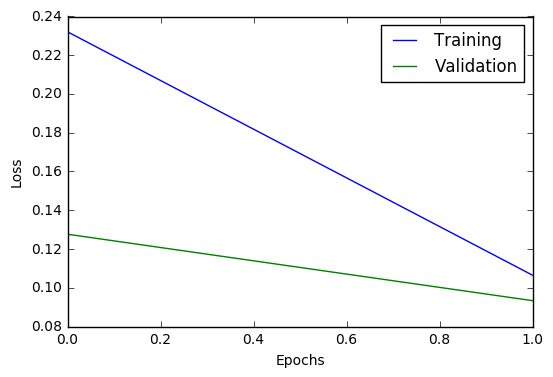

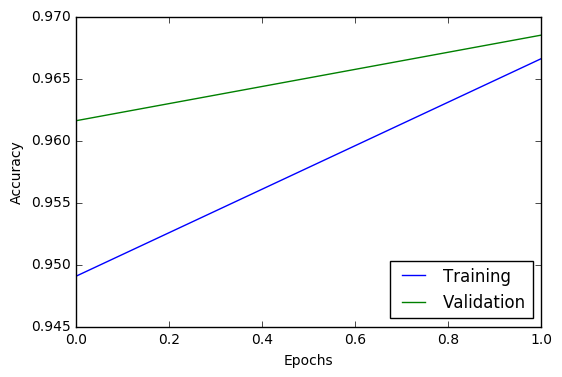

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

### Step 4: Evaluate

In [19]:
print('Available Metrics in Model: {}'.format(model.metrics_names))

Available Metrics in Model: ['loss', 'acc']


In [20]:
# Evaluating the model on the test data    
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Test Loss: 0.093337612465
Test Accuracy: 0.9685


### Let's plot our model Predictions!

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline

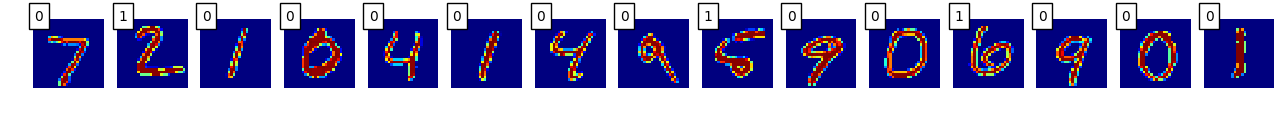

In [22]:
slice = 15
predicted = model.predict(X_test[:slice]).argmax(-1)

plt.figure(figsize=(16,8))
for i in range(slice):
    plt.subplot(1, slice, i+1)
    plt.imshow(X_test_orig[i], interpolation='nearest')
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

# Adding more Dense Layers

In [23]:
model = Sequential()
model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                 padding='valid', input_shape=shape_ord))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test))

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 24s - loss: 0.1963 - acc: 0.9456 - val_loss: 0.0869 - val_acc: 0.9720
Epoch 2/2
11918/11918 [==============================] - 23s - loss: 0.0897 - acc: 0.9707 - val_loss: 0.0889 - val_acc: 0.9686


In [25]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.0889245147899
Test accuracy: 0.9686


# Adding Dropout

In [26]:
model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                        padding='valid',
                        input_shape=shape_ord))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test))

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 23s - loss: 0.2460 - acc: 0.9343 - val_loss: 0.1821 - val_acc: 0.9353
Epoch 2/2
11918/11918 [==============================] - 24s - loss: 0.1058 - acc: 0.9653 - val_loss: 0.0975 - val_acc: 0.9650


In [29]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.0974913226381
Test accuracy: 0.965


# Adding more Convolution Layers

In [31]:
model = Sequential()
model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                 padding='valid', input_shape=shape_ord))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, (nb_conv, nb_conv)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))
    
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [32]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, 
          epochs=nb_epoch,verbose=1,
          validation_data=(X_test, Y_test))

Train on 11918 samples, validate on 10000 samples
Epoch 1/2
11918/11918 [==============================] - 47s - loss: 0.3828 - acc: 0.8569 - val_loss: 0.1740 - val_acc: 0.9406
Epoch 2/2
11918/11918 [==============================] - 46s - loss: 0.1419 - acc: 0.9523 - val_loss: 0.0779 - val_acc: 0.9733


In [33]:
#Evaluating the model on the test data    
score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Test score: 0.0779156615257
Test accuracy: 0.9733
